In [7]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

dist = 'euclidean'
    

## Reading Homogenoues MIMIC-III similarity matrices

In [8]:
import pickle

# Load data from the file
with open('data/MIMIC-III/GCN emb/sim.pkl', 'rb') as file:
    sim = pickle.load(file)

with open('data/MIMIC-III/GCN emb/y.pkl', 'rb') as file:
    Y = pickle.load(file)

with open('data/MIMIC-III/GCN emb/Nodes.pkl', 'rb') as file:
    Nodes = pickle.load(file)


sim[sim < 0] = 0

In [9]:
df = pd.read_csv('data/MIMIC-III/GCN emb/survival.csv')[['SUBJECT_ID','ADMITTIME','DEATHTIME']]

# Convert datetime columns to datetime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'])

# Calculate time difference in days between ADMITTIME and DEATHTIME
df['DAYS'] = (df['DEATHTIME'] - df['ADMITTIME']).dt.days
df['STATUS'] = df['DEATHTIME'].notnull().astype(int)

df['DAYS'].fillna(60, inplace=True)

from datetime import timedelta

df

,SUBJECT_ID,ADMITTIME,DEATHTIME,DAYS,STATUS
0,56,2104-01-02 02:01:00,2104-01-08 10:30:00,6.0,1
1,103,2144-08-12 17:37:00,2144-09-01 14:28:00,19.0,1
2,150,2161-07-09 17:54:00,NaT,60.0,0
3,222,2142-06-11 07:15:00,NaT,60.0,0
4,281,2101-10-18 04:42:00,2101-10-25 19:10:00,7.0,1
...,...,...,...,...,...
993,99339,2145-10-14 02:26:00,NaT,60.0,0
994,99384,2117-11-29 07:15:00,NaT,60.0,0
995,99469,2183-04-16 23:20:00,2183-05-13 16:20:00,26.0,1
996,99556,2165-12-25 12:44:00,2167-07-31 21:53:00,583.0,1


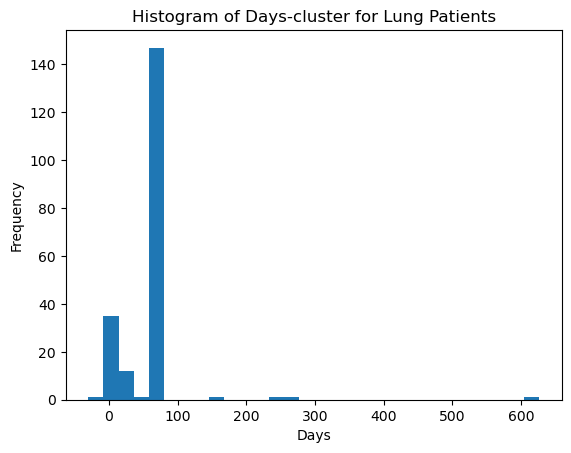

236.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   163.0                   627.0
P-value = (0,1) 0.009265767969057023


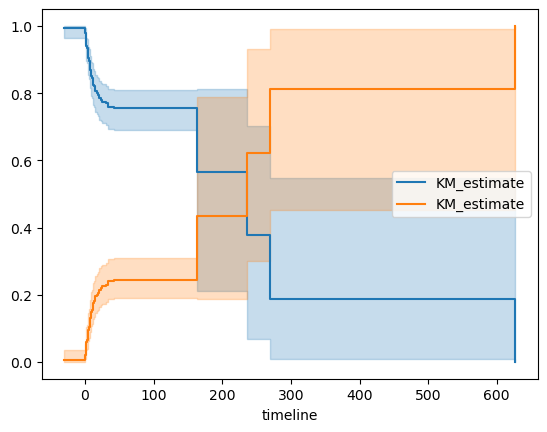

In [10]:
Lung_labels = spectral_clustering(sim, n_clusters=2)
Lung_patients = [i.split('_')[1] for i in Nodes]

df_lung = pd.DataFrame({'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels) })
df_lung['SUBJECT_ID'] = df_lung['SUBJECT_ID'].astype(int)

Lung_survival = pd.merge(df_lung, df, on='SUBJECT_ID')

data = Lung_survival

T = data['DAYS']
E = data['STATUS']

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram of Days-cluster for Lung Patients')
plt.hist(T, bins = 30)
plt.show()

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot()

kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
groups = dict(tuple(Lung_survival.groupby('cluster')))
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)

# 2 Clusters for Lung

Number of patients in cluser 0 = 173
Number of patients in cluser 1 = 27
inf
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                  12.0                   inf
P-value = (0,1) 0.009265767969057023


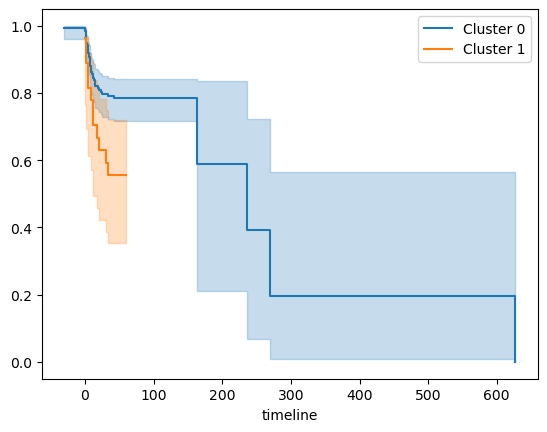

In [11]:
Lung_labels = spectral_clustering(sim, n_clusters=2)

df_lung = pd.DataFrame({'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels) })
df_lung['SUBJECT_ID'] = df_lung['SUBJECT_ID'].astype(int)

Lung_survival = pd.merge(df_lung, df, on='SUBJECT_ID')

data = Lung_survival

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)

# 3 clusters for Lung
- find the clustering...


Number of patients in cluser 0 = 169
Number of patients in cluser 1 = 10
Number of patients in cluser 2 = 21
inf
     Cluster 2_lower_0.95  Cluster 2_upper_0.95
0.5                  33.0                   inf
P-value = (0,1) 0.004881218595756947
P-value = (0,2) 0.4985956923760959
P-value = (1,2) 0.09797390917618048


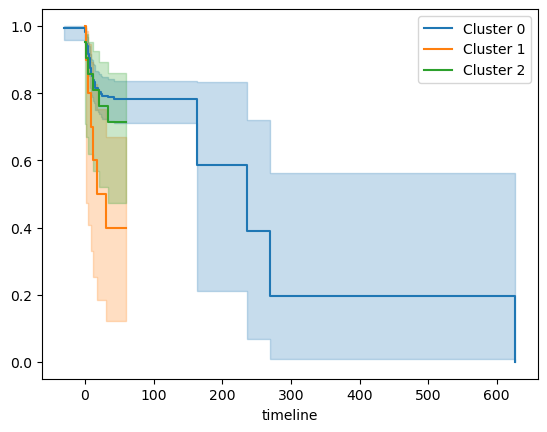

In [12]:
Lung_labels = spectral_clustering(sim, n_clusters=3)

df_lung = pd.DataFrame({'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels) })
df_lung['SUBJECT_ID'] = df_lung['SUBJECT_ID'].astype(int)

Lung_survival = pd.merge(df_lung, df, on='SUBJECT_ID')

data = Lung_survival

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)